# NRP Figures

This notebook provides the code used to make the base figures in the NRP paper (along with the accompanying data). If you have any questions, please contact Josh Speagle at j.speagle@utoronto.ca.

# Preamble

Just setting up some basic commands and plotting environment style.

In [1]:
import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from astropy.io import fits
from sklearn.neighbors import KernelDensity
from scipy.stats import norm

In [2]:
# plot in-line within the notebook
%matplotlib inline

# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 30})

In [3]:
# fix random seed to ensure exact reproducibility
np.random.seed(2021)

# Data

Load in the data.

In [4]:
# load data for NGC 2682 (M67) star cluster
hdu = fits.open('NGC_2682.fits')
data = hdu[1].data

# extract membership probabilities from kinematics (Gaia DR2)
pmem = data['HDBscan_MemProb']

# extract parallaxes (Gaia DR2)
# note: no corrections have been applied for any systematics
p, pe = data['Parallax'], data['Parallax_Err']

In [5]:
# get lowest SNR parallax
idx_min = np.argmin(p/pe)

# Figure 1: Likelihood, Prior, and Posterior

We'll illustrate the impact of various priors on the likelihood using a series of random draws.

In [6]:
# likelihood
# deliberately shift mean and inflate errors for illustrative purposes
pdraws = np.random.normal(p[idx_min] - 0.5, pe[idx_min] * 3, size=int(1e8))

# prior 1: uniform in parallax
prior_unif_parallax = np.random.uniform(0, 5, size=int(1e8))

# prior 2: uniform in distance
prior_unif_dist = np.random.uniform(0, 10, size=int(1e8))

In [7]:
# histogram our data in both parallax and distance

# prior 1: uniform in parallax
y, bins_p = np.histogram(pdraws, bins=np.linspace(-4, 5, 2501))
cents_p = (bins_p[1:] + bins_p[:-1]) / 2.
yp_par, _ = np.histogram(prior_unif_parallax, bins=bins_p)
yp_dist, _ = np.histogram(1. / prior_unif_dist, bins=bins_p)

# prior 2: uniform in distance
y2, bins_d = np.histogram(1./pdraws, bins=np.linspace(0, 10, 2501))
cents_d = (bins_d[1:] + bins_d[:-1]) / 2.
y2p_par, _ = np.histogram(1. / prior_unif_parallax, bins=bins_d)
y2p_dist, _ = np.histogram(prior_unif_dist, bins=bins_d)

In [8]:
# prior 3: EDSD (Bailer-Jones et al. 2018)

# compute function over corresponding bins
y3 = cents_d**2 * np.exp(-cents_d / 1.)
y3 /= y3.sum()

# use inverse-CDF sampling to draw from prior
y3p_draws = np.interp(np.random.uniform(0, 1, size=int(1e8)), y3.cumsum(), cents_d)

# histogram data
y3p_par, _ = np.histogram(1. / y3p_draws, bins=bins_p)
y3p_dist, _ = np.histogram(y3p_draws, bins=bins_d)

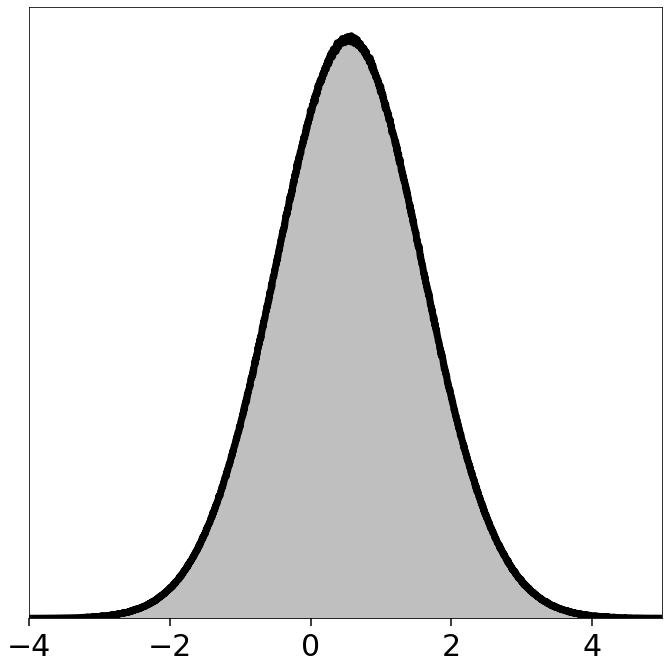

In [9]:
# plot likelihood (parallax)
plt.figure(figsize=(10, 10))
plt.fill_between(cents_p, y, color='gray', alpha=0.5)
plt.plot(cents_p, y, color='black', lw=7)
plt.xlim([-4, 5])
plt.ylim([0, None])
#plt.xlabel('Parallax [mas]')
plt.yticks([])
#plt.ylabel('Probability [normalized]')
plt.tight_layout()
#plt.savefig('likelihood_lowsnr.png', bbox_inches='tight')

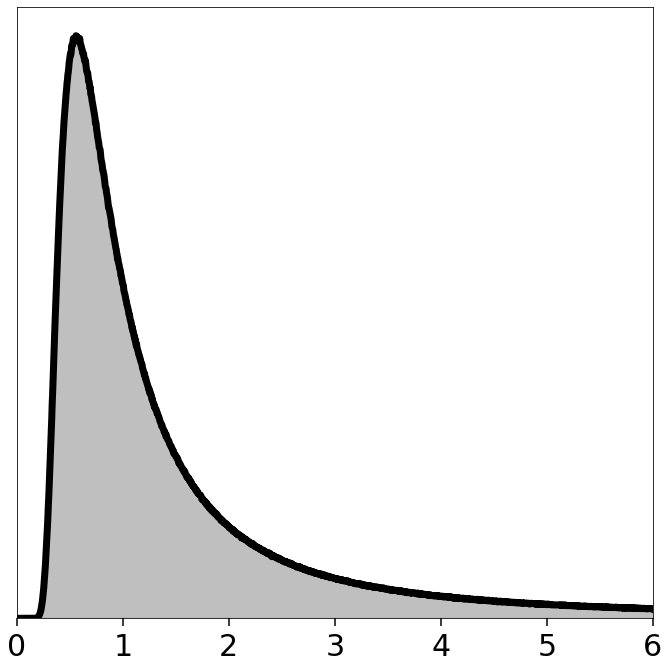

In [10]:
# plot likelihood (distance)
plt.figure(figsize=(10, 10))
plt.fill_between(cents_d, y2, color='gray', alpha=0.5)
plt.plot(cents_d, y2, color='black', lw=7)
plt.xlim([0, 6])
plt.ylim([0, None])
#plt.xlabel('Distance [kpc]')
plt.yticks([])
#plt.ylabel('Probability [normalized]')
plt.tight_layout()
#plt.savefig('likelihood2_lowsnr.png', bbox_inches='tight')

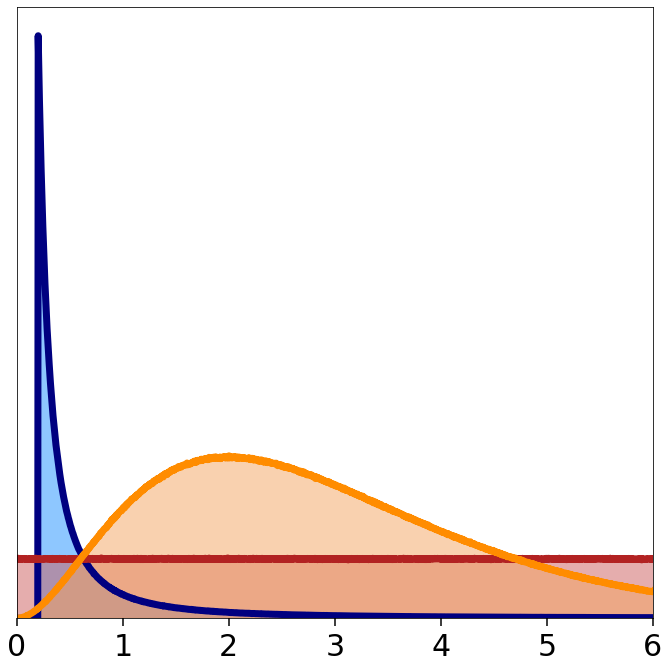

In [11]:
# plot priors (distance)
plt.figure(figsize=(10, 10))
plt.fill_between(cents_d, y2p_par / 5., color='dodgerblue', alpha=0.5)
plt.plot(cents_d, y2p_par / 5., color='navy', lw=7)
plt.fill_between(cents_d, y2p_dist, color='indianred', alpha=0.5)
plt.plot(cents_d, y2p_dist, color='firebrick', lw=7)
plt.fill_between(cents_d, y3p_dist, color='sandybrown', alpha=0.5)
plt.plot(cents_d, y3p_dist, color='darkorange', lw=7)
plt.xlim([0, 6])
#plt.xlabel('Distance [kpc]')
plt.ylim([0, None])
plt.yticks([])
#plt.ylabel('Probability [normalized]')
plt.tight_layout()
#plt.savefig('priors_lowsnr.png', bbox_inches='tight')

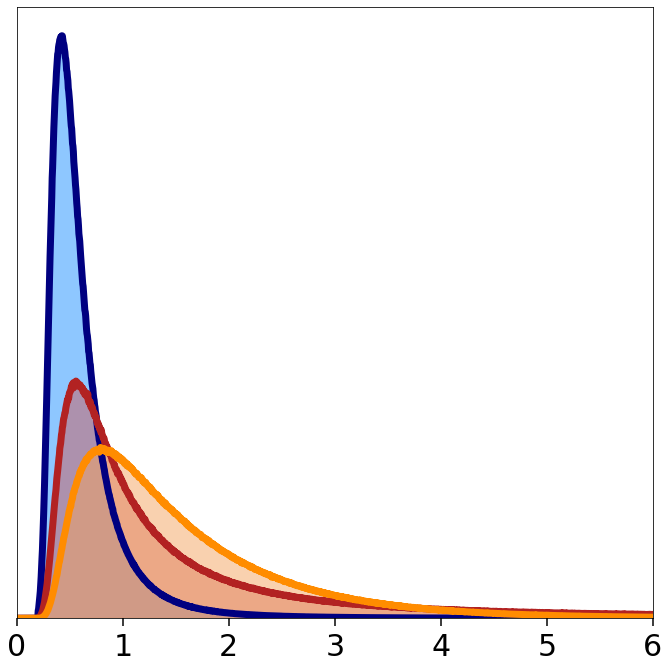

In [12]:
# plot posteriors (distance)
plt.figure(figsize=(10, 10))
plt.fill_between(cents_d, y2p_par * y2 / sum(y2p_par * y2), color='dodgerblue', alpha=0.5)
plt.plot(cents_d, y2p_par * y2 / sum(y2p_par * y2), color='navy', lw=7)
plt.fill_between(cents_d, y2p_dist * y2 / sum(y2p_dist * y2), color='indianred', alpha=0.5)
plt.plot(cents_d, y2p_dist * y2 / sum(y2p_dist * y2), color='firebrick', lw=7)
plt.fill_between(cents_d, y3p_dist * y2 / sum(y3p_dist * y2), color='sandybrown', alpha=0.5)
plt.plot(cents_d, y3p_dist * y2 / sum(y3p_dist * y2), color='darkorange', lw=7)
plt.xlim([0, 6])
#plt.xlabel('Distance [kpc]')
plt.ylim([0, None])
#plt.ylabel('Probability [normalized]')
plt.yticks([])
plt.tight_layout()
#plt.savefig('posteriors_lowsnr.png', bbox_inches='tight')

# Figure 2: Summary Statistics

Using our previous posteriors, we'll highlight a few summary statistics.

In [13]:
# compute median and 95% CIs
y2p_par_med = cents_d[np.argmin(np.abs(np.cumsum(y2p_par * y2 / sum(y2p_par * y2)) - 0.5))]
y2p_par_ci = [cents_d[np.argmin(np.abs(np.cumsum(y2p_par * y2 / sum(y2p_par * y2)) - ci))]
              for ci in [0.05, 0.95]]
y2p_dist_med = cents_d[np.argmin(np.abs(np.cumsum(y2p_dist * y2 / sum(y2p_dist * y2)) - 0.5))]
y2p_dist_ci = [cents_d[np.argmin(np.abs(np.cumsum(y2p_dist * y2 / sum(y2p_dist * y2)) - ci))]
               for ci in [0.05, 0.95]]
y3p_dist_med = cents_d[np.argmin(np.abs(np.cumsum(y3p_dist * y2 / sum(y3p_dist * y2)) - 0.5))]
y3p_dist_ci = [cents_d[np.argmin(np.abs(np.cumsum(y3p_dist * y2 / sum(y3p_dist * y2)) - ci))]
               for ci in [0.05, 0.95]]
print('Posterior 1:', y2p_par_med, y2p_par_ci)
print('Posterior 2:', y2p_dist_med, y2p_dist_ci)
print('Posterior 3:', y3p_dist_med, y3p_dist_ci)

# compute modes
y2p_par_mode = cents_d[np.argmax(y2p_par * y2)]
y2p_dist_mode = cents_d[np.argmax(y2p_dist * y2)]
y3p_dist_mode = cents_d[np.argmax(y3p_dist * y2)]
print('Modes:', y2p_par_mode, y2p_dist_mode, y3p_dist_mode)

Posterior 1: 0.53 [0.302, 1.286]
Posterior 2: 0.998 [0.402, 5.154]
Posterior 3: 1.274 [0.51, 3.542]
Modes: 0.426 0.558 0.79


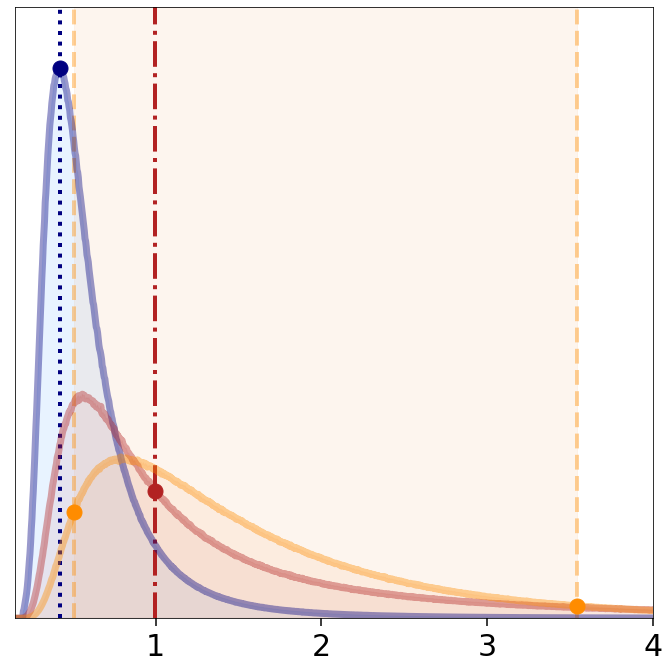

In [14]:
# zoomed-in version w/ median and CIs
plt.figure(figsize=(10, 10))
plt.fill_between(cents_d, y2p_par * y2 / sum(y2p_par * y2), color='dodgerblue', alpha=0.1)
plt.plot(cents_d, y2p_par * y2 / sum(y2p_par * y2), color='navy', lw=7, alpha=0.4)
plt.vlines(y2p_par_mode, 0, 1, color='navy', lw=4, ls='dotted')
plt.plot(y2p_par_mode, np.interp(y2p_par_mode, cents_d, y2p_par * y2 / sum(y2p_par * y2)), 
         color='navy', marker='o', markersize=15)
plt.fill_between(cents_d, y2p_dist * y2 / sum(y2p_dist * y2), color='indianred', alpha=0.1)
plt.plot(cents_d, y2p_dist * y2 / sum(y2p_dist * y2), color='firebrick', lw=7, alpha=0.4)
plt.vlines(y2p_dist_med, 0, 1, color='firebrick', lw=4, ls='-.')
plt.plot(y2p_dist_med, np.interp(y2p_dist_med, cents_d, y2p_dist * y2 / sum(y2p_dist * y2)), 
         color='firebrick', marker='o', markersize=15)
plt.fill_between(cents_d, y3p_dist * y2 / sum(y3p_dist * y2), color='sandybrown', alpha=0.1)
plt.plot(cents_d, y3p_dist * y2 / sum(y3p_dist * y2), color='darkorange', lw=7, alpha=0.4)
plt.fill_between(y3p_dist_ci, 0, 1, color='sandybrown', alpha=0.1)
plt.vlines(y3p_dist_ci, 0, 1, color='darkorange', lw=4, ls='--', alpha=0.4)
plt.plot(y3p_dist_ci, np.interp(y3p_dist_ci, cents_d, y3p_dist * y2 / sum(y3p_dist * y2)), 
         color='darkorange', marker='o', markersize=15, ls='none')
plt.xlim([0.15, 4.0])
#plt.xlabel('Distance [kpc]')
plt.ylim([0, 1e-2])
#plt.ylabel('Probability [normalized]')
plt.yticks([])
plt.tight_layout()
#plt.savefig('posteriors_lowsnr_zoom.png', bbox_inches='tight')

# Figure 3: Cluster (M67)

Using data for the cluster, we'll now illustrate a more extended example of how to combine data and check the final model using posterior predictives and q-q plots.

In [15]:
# sort data in ascending SNR
idx_asc = np.argsort(p/pe)

# shuffle order (unordered results)
#np.random.shuffle(idx_asc)

# apply membership probability cutoff
sel = idx_asc[pmem[idx_asc] > 0.3]

# define Gaussian prior
prior_mean, prior_std = np.full_like(p[sel], 1.2), np.full_like(p[sel], 0.1)

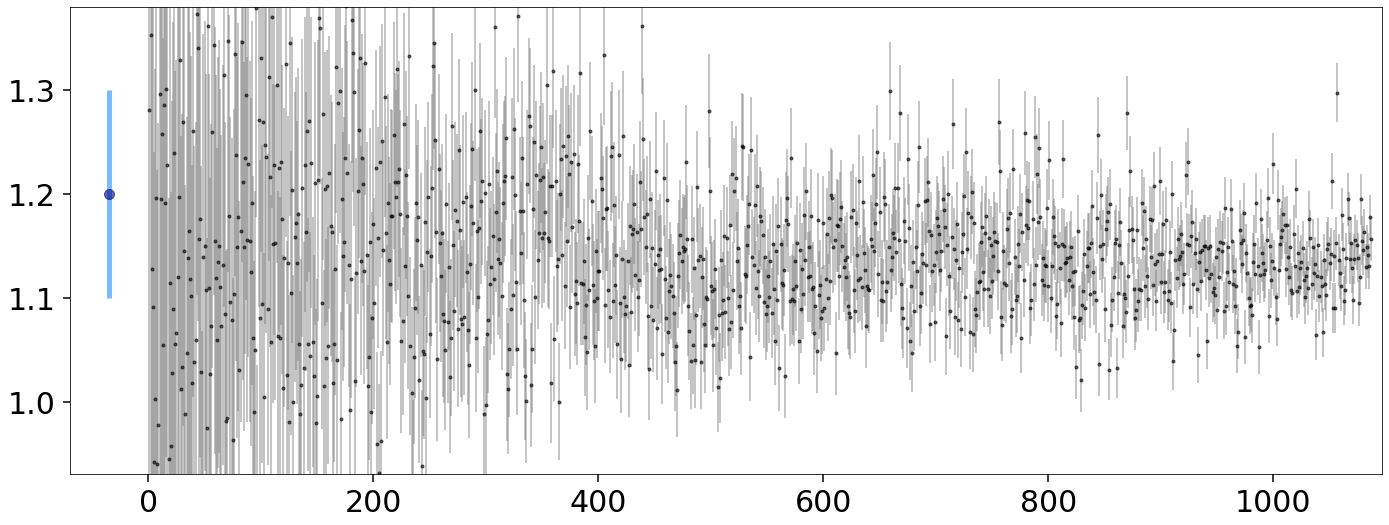

In [16]:
# plot prior and measurements
plt.figure(figsize=(20, 8))
plt.errorbar(np.arange(1, len(sel) + 1), p[sel], yerr=pe[sel], 
             linestyle='none', ecolor='gray', alpha=0.6, marker='.', color='black')
plt.errorbar(-35, prior_mean[0], yerr=prior_std[0], 
             linestyle='none', ecolor='dodgerblue', alpha=0.6, marker='o', markersize=10, lw=5, color='navy')
plt.xlim([-70, len(sel) + 10])
#plt.xlabel('Number of objects')
plt.ylim([0.93, 1.38])
#plt.ylabel('Measured parallax [mas]')
plt.tight_layout()
#plt.savefig('data_ind.png', bbox_inches='tight')

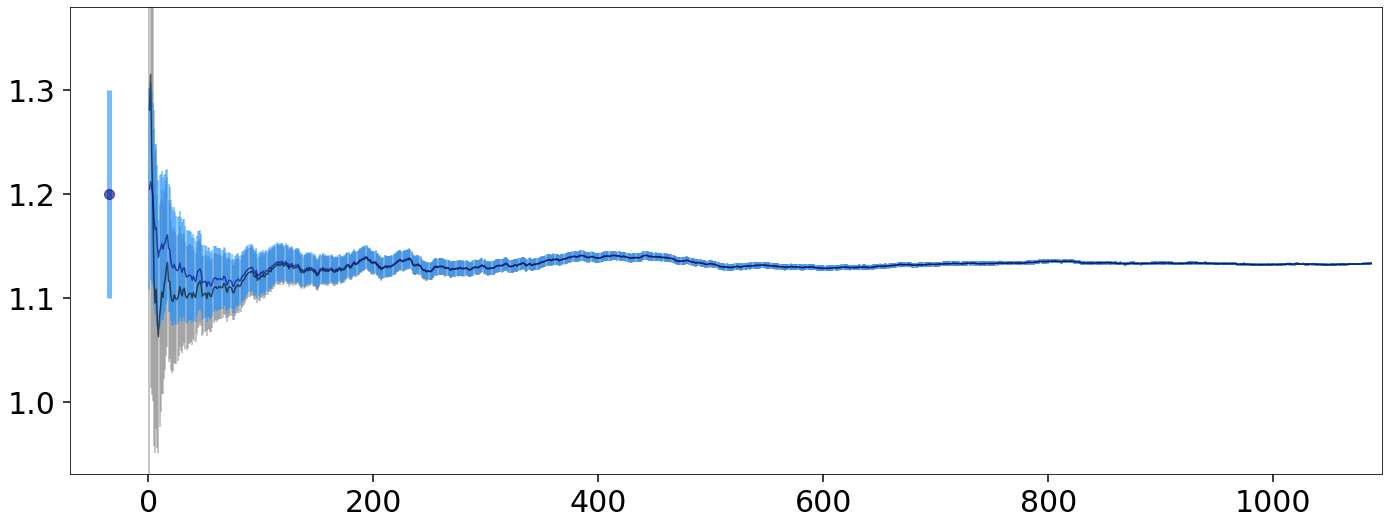

In [17]:
# compute joint likelihood as we sequentially add more data
wivar = np.cumsum(1. / pe[sel]**2)
wmean = np.cumsum(p[sel] / pe[sel]**2) / wivar

# compute joint posterior as we add more data
wivar_post = wivar + 1. / prior_std**2
wmean_post = (wmean * wivar + prior_mean / prior_std**2) / wivar_post

# plot prior, joint likelihood, and joint posterior
plt.figure(figsize=(20, 8))
plt.errorbar(-35, prior_mean[0], yerr=prior_std[0], 
             linestyle='none', ecolor='dodgerblue', alpha=0.6, marker='o', markersize=10, lw=5, color='navy')
plt.errorbar(np.arange(1, len(sel) + 1), wmean, yerr=wivar**-0.5, 
             ecolor='gray', alpha=0.6, color='black')
plt.errorbar(np.arange(1, len(sel) + 1), wmean_post, yerr=wivar_post**-0.5, 
             ecolor='dodgerblue', alpha=0.6, color='navy')
plt.xlim([-70, len(sel) + 10])
#plt.xlabel('Number of objects')
plt.ylim([0.93, 1.38])
#plt.xlabel('Inferred Parallax [mas]')
plt.tight_layout()
#plt.savefig('data_likepost2.png', bbox_inches='tight')

In [18]:
# generate data realization from posterior
p_post = np.random.normal(wmean_post[-1], wivar_post[-1]**-0.5, size=len(sel))

# generate data realization (sample) from posterior predictive
p_postpred = np.random.normal(p_post, pe[sel])

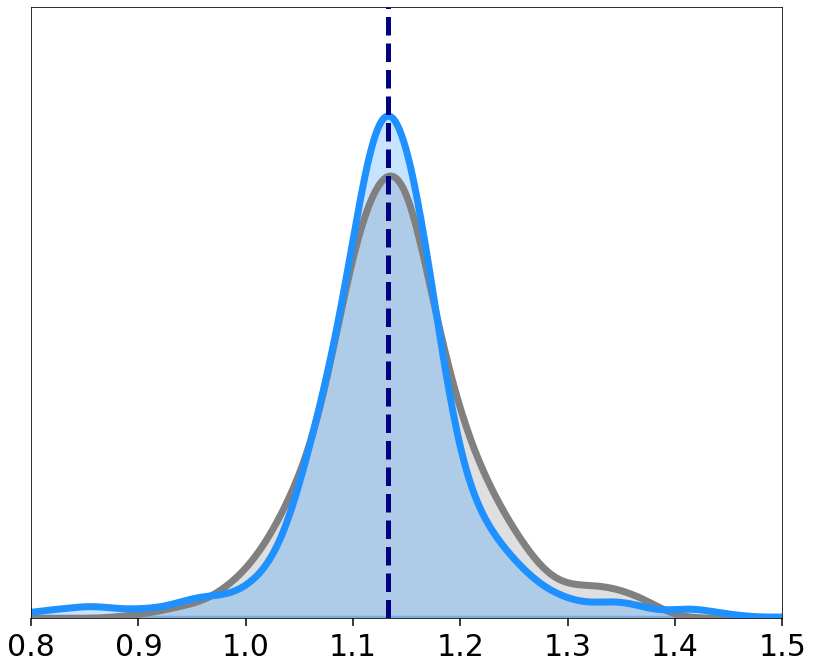

In [19]:
# plot 1-D distribution estimate
plt.figure(figsize=(12, 10))
X = np.linspace(0, 2, 1000)
plt.plot(X, np.exp(KernelDensity(bandwidth=0.02)
                   .fit(p[sel].reshape(-1, 1))
                   .score_samples(X.reshape(-1, 1))),
         lw=7, color='gray')
plt.fill_between(X, np.exp(KernelDensity(bandwidth=0.02)
                           .fit(p[sel].reshape(-1, 1))
                           .score_samples(X.reshape(-1, 1))),
                 lw=5, color='gray', alpha=0.25)
plt.plot(X, np.exp(KernelDensity(bandwidth=0.02)
                   .fit(p_postpred.reshape(-1, 1))
                   .score_samples(X.reshape(-1, 1))),
         lw=7, color='dodgerblue')
plt.fill_between(X, np.exp(KernelDensity(bandwidth=0.02)
                           .fit(p_postpred.reshape(-1, 1))
                           .score_samples(X.reshape(-1, 1))),
                 lw=5, color='dodgerblue', alpha=0.25)
plt.vlines(wmean_post[-1], 0, 9, color='navy', lw=5, ls='dashed', zorder=10)
plt.xlim([0.8, 1.5])
plt.ylim([0, 9])
plt.yticks([])
plt.tight_layout()
#plt.savefig('data_postpred.png', bbox_inches='tight')

In [20]:
# define quantiles (percentiles = quantiles * 100)
percentiles = np.arange(1, 100, 1)

# compute data quantiles
pct_data = np.percentile(p[sel], percentiles)
pct_post = np.percentile(p_postpred, percentiles)

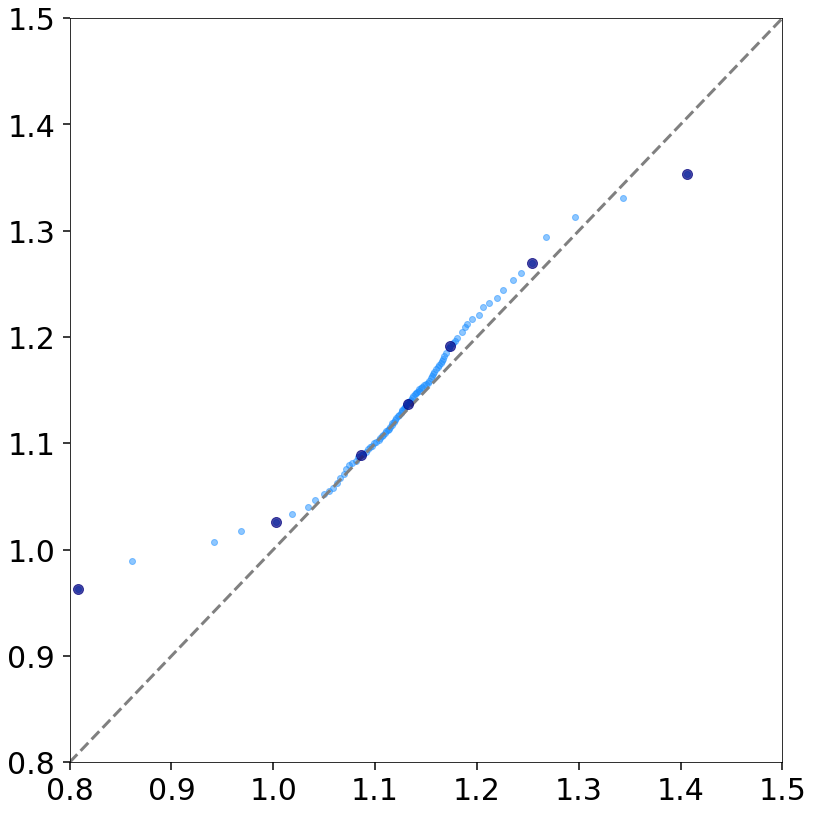

In [21]:
# plot quantile-quantile comparison for a few posterior predictive samples
plt.figure(figsize=(12, 12))
plt.plot(pct_post, pct_data, 'o', color='dodgerblue', alpha=0.5, lw=3)
plt.plot(np.interp([1, 5, 20, 50, 80, 95, 99], percentiles, pct_post),
         np.interp([1, 5, 20, 50, 80, 95, 99], percentiles, pct_data),
         marker='o', markersize=10, alpha=0.7, ls='none', color='navy', zorder=10)
plt.plot([0.8, 1.5], [0.8, 1.5], ls='--', lw=3, color='gray')
plt.xlim([0.8, 1.5])
plt.ylim([0.8, 1.5])
plt.tight_layout()
#plt.savefig('data_postpred_qq.png', bbox_inches='tight')